<a href="https://colab.research.google.com/github/dimpapac/CNN_ANN_LSH_EMD_Clustering/blob/main/latent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)
train_images (60000, 28, 28, 1)
#layers batch_size epochs: 3 512 10

#total_filters #filter_size : 32 3
#total_filters #filter_size : 64 3
#total_filters #filter_size : 128 3
already added max amount of pooling
Please give latent dimension : 10
Model: "functional_81"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_27 (InputLayer)        [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_109 (Conv2D)          (None, 28, 28, 32)        320       
_________________________________________________________________
batch_normalization_92 (Batc (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d_38 (MaxPooling (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_110 (Conv2D)   

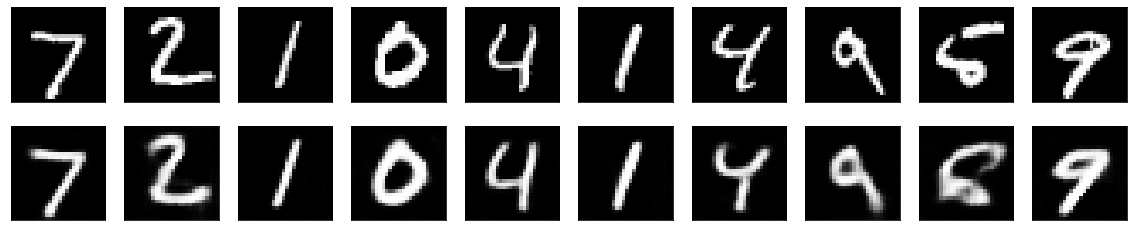

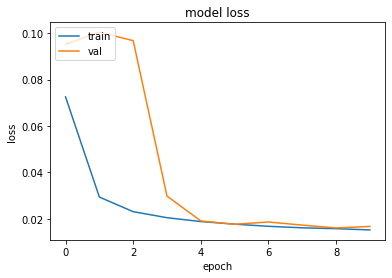

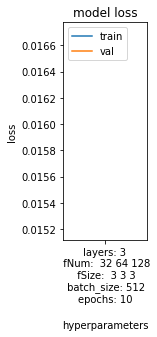

In [33]:
import os
import sys
import struct as st
import numpy as np
import keras
import sklearn
import matplotlib.pyplot as plt #Graph
from keras import backend as k
from keras import layers, optimizers, losses, metrics
from keras.models import Model #ANN architecture
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, BatchNormalization, Dropout, Flatten, Reshape
from sklearn.model_selection import train_test_split


# dataset = ""
# flag = 1

# if len(sys.argv) != 3:
# 	print("Usage: $python autoencoder.py -d <dataset>")
# 	sys.exit()

# for i in range(len(sys.argv)):
# 	if sys.argv[i] == "-d":
# 	    dataset = sys.argv[i+1]
# 	    flag-=1

# if flag!=0:
# 	print("Usage: $python autoencoder.py -d <dataset>")
# 	sys.exit()


# print("i: ", dataset)


# trainfilename = {'images' : './data/train-images.idx3-ubyte' ,'labels' : './data/train-labels.idx1-ubyte'}
# testfilename = {'images' : './data/t10k-images.idx3-ubyte' ,'labels' : './data/t10k-labels.idx1-ubyte'}

with open('/content/drive/My Drive/project3/data/train-images.idx3-ubyte','rb') as f:
# with open(dataset,'rb') as f:
    magic, size = st.unpack(">II", f.read(8))
    nrows, ncols = st.unpack(">II", f.read(8))
    train_images = np.fromfile(f, dtype=np.dtype(np.uint8).newbyteorder('>'))
    train_images = train_images.reshape((size, nrows, ncols))
print(train_images.shape)


with open('/content/drive/My Drive/project3/data/train-labels.idx1-ubyte','rb') as f:
    magic, size = st.unpack(">II", f.read(8))
    # nrows, ncols = st.unpack(">II", f.read(8))
    train_labels = np.fromfile(f, dtype=np.dtype(np.uint8).newbyteorder('>'))
    train_labels = train_labels.reshape((size))
print(train_labels.shape)


with open('/content/drive/My Drive/project3/data/t10k-images.idx3-ubyte','rb') as f:
    magic, size = st.unpack(">II", f.read(8))
    nrows, ncols = st.unpack(">II", f.read(8))
    test_images = np.fromfile(f, dtype=np.dtype(np.uint8).newbyteorder('>'))
    test_images = test_images.reshape((size, nrows, ncols))
print(test_images.shape)

with open('/content/drive/My Drive/project3/data/t10k-labels.idx1-ubyte','rb') as f:
    magic, size = st.unpack(">II", f.read(8))
    # nrows, ncols = st.unpack(">II", f.read(8))
    test_labels = np.fromfile(f, dtype=np.dtype(np.uint8).newbyteorder('>'))
    test_labels = test_labels.reshape((size))
print(test_labels.shape)

train_images = (train_images/255) #normalize
test_images = (test_images/255) #normalize

train_images = np.reshape(train_images, (len(train_images), 28, 28, 1))

print("train_images", train_images.shape) #60.000 rows

loss = []
val_loss = []
text_values = []

usr_input = '1'
while (usr_input == '1'):
    
    #input from user
    layers, batch_size, epochs = input("#layers batch_size epochs: ").split()

    #accept only digits
    if  (not(layers.isdigit()) or not(batch_size.isdigit()) or not(epochs.isdigit())):
        print("wrong input")
        sys.exit()
    print()

    layersNum = int(layers)
    batchSize = int(batch_size)
    epochsNum = int(epochs)
    input_img = Input(shape=(28, 28, 1)) 

    #input = 28 x 28 x 1 (wide and thin)
    x = input_img
    pooling_counter = 0
    latent = 0

    #keep every layer's info to use it in the decoder (mirror)
    layer_info = []

    for i in range(0, layersNum):

        # Ask for number of filters ,filtersize and if you want pooling
        filter_flag = 1
        while filter_flag :
            filters, filter_size  = input("#total_filters #filter_size : ").split()
            #accept only digits
            if  (not(filters.isdigit()) or not(filter_size.isdigit())):
                print("please enter ints")
            else:
                filtersNum = int(filters)
                filterSize = int(filter_size)
                filter_flag = 0

        pooling_flag = 1
        pool = 'n'
        while pooling_flag :
            # pool = input("Do you want to add pooling to this layer? [Y/n]")
            pool = 'Y'
            # Accept only Y or n
            if ( pool != 'Y' and pool != 'n' ) :
                print("please enter Y (yes) or n (no)")
            else :
                if pooling_counter == 2 and pool == 'Y' :
                    print("already added max amount of pooling")
                    pool = 'n'
                else :
                    if( pool == 'Y' ) :
                        pooling_counter += 1
                pooling_flag = 0

        # For each layer of the encoder keep the parameters used so we can use them on the right layers on the decoder
        info = [filtersNum,filterSize,pool]
        layer_info.insert(0,info)

        #encoder
        x = Conv2D(filtersNum, (filterSize, filterSize), activation='relu', padding='same' )(x)
        x = BatchNormalization()(x)
        if pool == 'Y' : #only in 2 first layers
            x = MaxPooling2D(pool_size=(2, 2))(x) 

    latent = input("Please give latent dimension : ")


    shape_before_flattening = k.int_shape(x)[1:]
    flat = Flatten()(x)
    lat = Dense(latent)(flat)

    encoder = Model(input_img, lat)

    #decoder
    x = Dense(np.prod(shape_before_flattening))(lat)
    x = Reshape(shape_before_flattening)(x)

    for i in range(0,layersNum):

        info = layer_info[i]
        filtersNum = info[0]
        filterSize = info[1]
        pool = info[2]

        #decoder
        x = Conv2D(filtersNum, (filterSize, filterSize), activation='relu', padding='same')(x)
        x = BatchNormalization()(x)
        if pool == 'Y' :
            x = UpSampling2D((2,2))(x) 


    decoded = Conv2D(1, (filterSize, filterSize), activation='sigmoid', padding='same')(x) # 28 x 28 x 1

    autoencoder = Model(input_img, decoded)
    autoencoder.compile(loss = 'mean_squared_error', optimizer = optimizers.RMSprop())

    autoencoder.summary()

    train_X,valid_X,train_ground,valid_ground = train_test_split(
        train_images,
        train_images,
        test_size=0.2,
        random_state=13
        )

    #fit model with given params
    autoencoder_train = autoencoder.fit(train_X, train_ground, 
        batch_size=batchSize,
        epochs=epochsNum,
        verbose=1,
        validation_data=(valid_X, valid_X)
        )

    # print(autoencoder_train.history.keys())
    loss.append(autoencoder_train.history['loss'][-1])
    val_loss.append(autoencoder_train.history['val_loss'][-1])
    
    str_text = ""
    str_num = ""
    str_size = ""
    for i in range(layersNum-1,-1,-1):
        info = layer_info[i]
        filtersNum = info[0]
        filterSize = info[1]
        str_num = str_num + " " + str(filtersNum)
        str_size = str_size + " " + str(filterSize)
    strr = "layers: %d\n fNum: %s\n fSize: %s\n batch_size: %d\nepochs: %d\n" % (layersNum, str_num, str_size, batchSize, epochsNum)
    text_values.append(strr)    
    # print(autoencoder_train.history['loss'])
    # print(autoencoder_train.history['val_loss'][-1])

    print("Options:")
    print("Press 1 to repeat with different hyperparameters")
    print("Press 2 to plot")
    print("Press 3 to save the model")
    usr_input = input("Input: ")

    if usr_input == '2':
        print("plot")

        decoded_imgs = autoencoder.predict(test_images)
        n = 10

        plt.figure(figsize=(20, 4))
        for i in range(n):
            # display original
            ax = plt.subplot(2, n, i + 1)
            plt.imshow(test_images[i].reshape(28, 28))
            plt.gray()
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)

            # display reconstruction
            ax = plt.subplot(2, n, i+1+n)
            plt.imshow(decoded_imgs[i].reshape(28, 28))
            plt.gray()
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
        plt.show()

        plt.plot(autoencoder_train.history['loss'])
        plt.plot(autoencoder_train.history['val_loss'])
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'val'], loc='upper left')
        plt.show()


        x_values = np.arange(0, len(text_values), 1)

        plt.figure(figsize=(len(text_values)*1.5, 4))
        plt.plot(loss)
        plt.plot(val_loss)
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('hyperparameters')
        plt.legend(['train', 'val'], loc='upper left')
        plt.xticks(x_values, text_values)
        plt.show()

    elif usr_input == '3':
        print("save model")

        autoencoder.save('autoencoder.h5')

        # save encoder part for classifier.py
        path = input("Give the path in which you want to save the model: ")
        print(path)
        if not os.path.exists(path):
            print('save directories...', flush=True)
            os.makedirs(path)
        encoder.save(path + '/latent.h5')


